# Criteo Intra Channel Attribution Modeling for Bidding (EDA)

## 1. Goal of the project


## 2. Overview data
This notebook analyses the data retrieved from [Kaggle](https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling/data). The dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user and if it was clicked, led to a conversion and if it was attributed to Criteo.

Columns of the dataset from [Kaggle](https://www.kaggle.com/datasets/sharatsachin/criteo-attribution-modeling)
- **timestamp**: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.  
- **uid**: a unique user identifier  
- **campaign**: a unique identifier for the campaign  
- **conversion 1**: if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)  
- **conversion_timestamp**: the timestamp of the conversion or -1 if no conversion was observed
conversion_id a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion  
- **attribution 1**: if the conversion was attributed to Criteo, 0 otherwise  
- **click 1**: if the impression was clicked, 0 otherwise  
- **click_pos**: the position of the click before a conversion (0 for first-click)  
- **click_nb**: number of clicks. More than 1 if there was several clicks before a conversion  
- **cost**: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)  
- **cpo**: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)  
- **time_since_last_click**: the time since the last click (in s) for the given impression  
- **cat[1-9]**: contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).  

| Column name | Description |
| --- | ----------- |
| timestamp | Timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.|
| uid | Unique user identifier|
| campaign | Unique identifier for the campaign|
| conversion 1 | If there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)|
| conversion_timestamp | The timestamp of the conversion or -1 if no conversion was observed conversion_id a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion |
| attribution 1 | If the conversion was attributed to Criteo, 0 otherwise |
| click 1 | If the impression was clicked, 0 otherwise |
| click_nb | Number of clicks. More than 1 if there was several clicks before a conversion |
| cost | The price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it) |
| cpo | The cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it) |
| time_since_last_click | The time since the last click (in s) for the given impression |
| cat[1-9] | Contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference). |

In [1]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from marketing_attribution_models import *

OSError: 'seaborn-white' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
# read in csv file and display first 5 rows of the datset
df = pd.read_csv("c:/Users/Maria/Desktop/ds_projects/attribution/data/raw/pcb_dataset_final.tsv", sep='\t')
df.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


In [ ]:
# check which columns are included in our dataframe
df.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9'],
      dtype='object')

In [ ]:
# Shape of the dataset
df.shape

(16468027, 22)

In [ ]:
# Check out our data-types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   timestamp              int64  
 1   uid                    int64  
 2   campaign               int64  
 3   conversion             int64  
 4   conversion_timestamp   int64  
 5   conversion_id          int64  
 6   attribution            int64  
 7   click                  int64  
 8   click_pos              int64  
 9   click_nb               int64  
 10  cost                   float64
 11  cpo                    float64
 12  time_since_last_click  int64  
 13  cat1                   int64  
 14  cat2                   int64  
 15  cat3                   int64  
 16  cat4                   int64  
 17  cat5                   int64  
 18  cat6                   int64  
 19  cat7                   int64  
 20  cat8                   int64  
 21  cat9                   int64  
dtypes: float64(2), i

In [ ]:
# Checking for missing values
df.isnull().sum()

timestamp                0
uid                      0
campaign                 0
conversion               0
conversion_timestamp     0
conversion_id            0
attribution              0
click                    0
click_pos                0
click_nb                 0
cost                     0
cpo                      0
time_since_last_click    0
cat1                     0
cat2                     0
cat3                     0
cat4                     0
cat5                     0
cat6                     0
cat7                     0
cat8                     0
cat9                     0
dtype: int64

In [ ]:
# Checking the number of unique user ids in the whole dataset:
unique_uids=df['uid'].unique()
print(f"There are {len(unique_uids)} unique user ids in the dataset.")

## 3. Identifying the category with the highest correlation with conversions

cat1
30763035    7309133
28928366    1842264
138937      1805672
25259032    1482500
1973606     1287574
27093701    1246750
5824233      611564
9312274      556188
5642940      326382
Name: count, dtype: int64


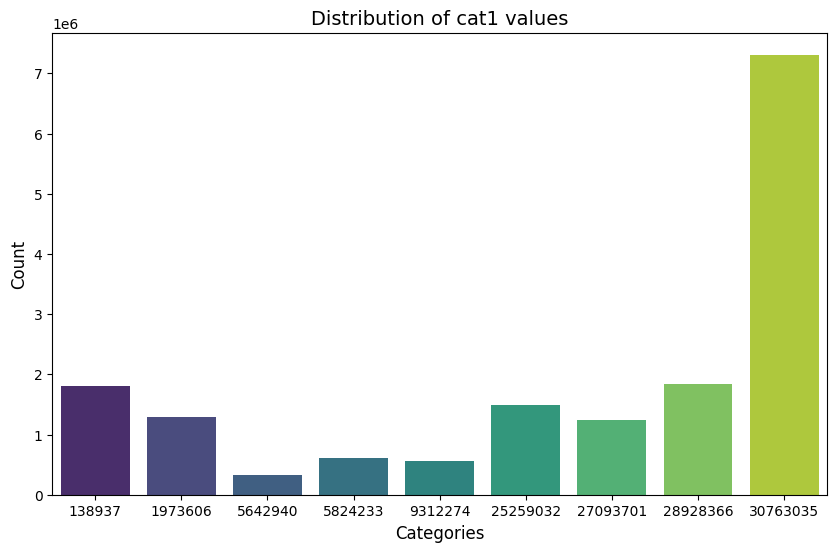

In [ ]:
cat1_counts = df['cat1'].value_counts()
print(cat1_counts)

plt.figure(figsize=(10,6))
sns.barplot(x=cat1_counts.index, y=cat1_counts.values, palette="viridis")
plt.title("Distribution of cat1 values", fontsize=14)
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

cat4
29196072    15292248
23549932      774763
17152695      201243
15743247       78630
6755486        61524
6855139        28841
358249         14218
26884401        9331
18454888        2821
22419795        2516
6025403         1079
30054645         373
16022558         178
17625160         141
Name: count, dtype: int64


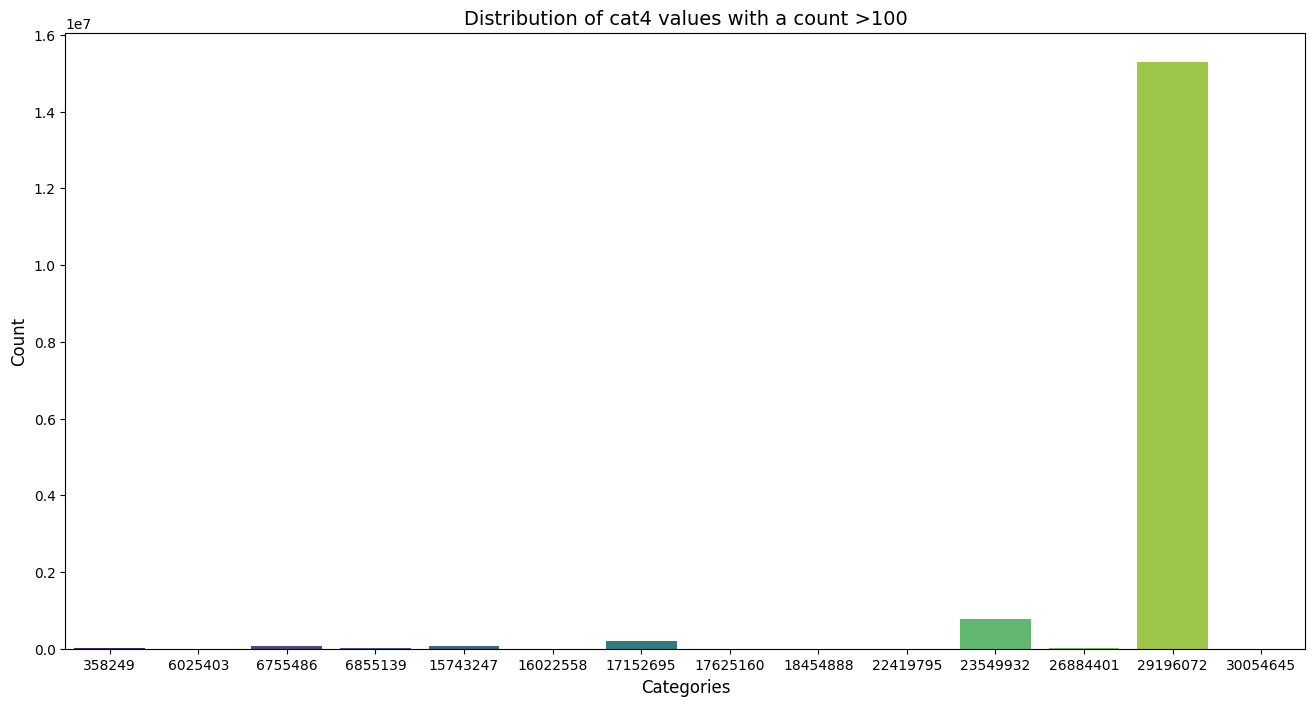

In [ ]:
cat4_counts = df['cat4'].value_counts()
cat4_counts_filtered = cat4_counts[cat4_counts > 100]
print(cat4_counts_filtered)

plt.figure(figsize=(16,8))
sns.barplot(x=cat4_counts_filtered.index, y=cat4_counts_filtered.values, palette="viridis")
plt.title("Distribution of cat4 values with a count >100", fontsize=14)
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [ ]:
def one_hot_encode_top_categories(df, columns_to_encode, top_n=2):
    '''aggregated_df = OneHotEncodeAndAggregate(df, ['column1', 'column2', 'column3'])'''
    df_encoded = df[['conversion']].copy()

    for col in columns_to_encode:
        top_categories = df[col].value_counts().nlargest(top_n).index
        df[col + '_filtered'] = df[col].where(df[col].isin(top_categories), other='OTHER')

        # Perform one-hot encoding for specified columns
        dummies = pd.get_dummies(df[col + '_filtered'], prefix=col)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)

    return df_encoded


In [ ]:
df_encoded = one_hot_encode_top_categories(df, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9'])
df_encoded.head(3)

,conversion,cat1_28928366,cat1_30763035,cat1_OTHER,cat2_9312274,cat2_26597095,cat2_OTHER,cat3_1423188,cat3_28051087,cat3_OTHER,...,cat6_OTHER,cat7_9312274,cat7_31785010,cat7_OTHER,cat8_29196072,cat8_32440044,cat8_OTHER,cat9_8661623,cat9_29196072,cat9_OTHER
0,0,False,False,True,True,False,False,False,False,True,...,False,False,False,True,True,False,False,False,True,False
1,0,False,True,False,True,False,False,False,False,True,...,False,False,False,True,False,False,True,False,False,True
2,0,False,False,True,True,False,False,False,False,True,...,True,False,False,True,True,False,False,False,False,True


In [ ]:
# Changing the boolean values to integers in the encoded columns
df_numeric = df.astype(int)
df_numeric.head()
corr_matrix = df_numeric.corr()

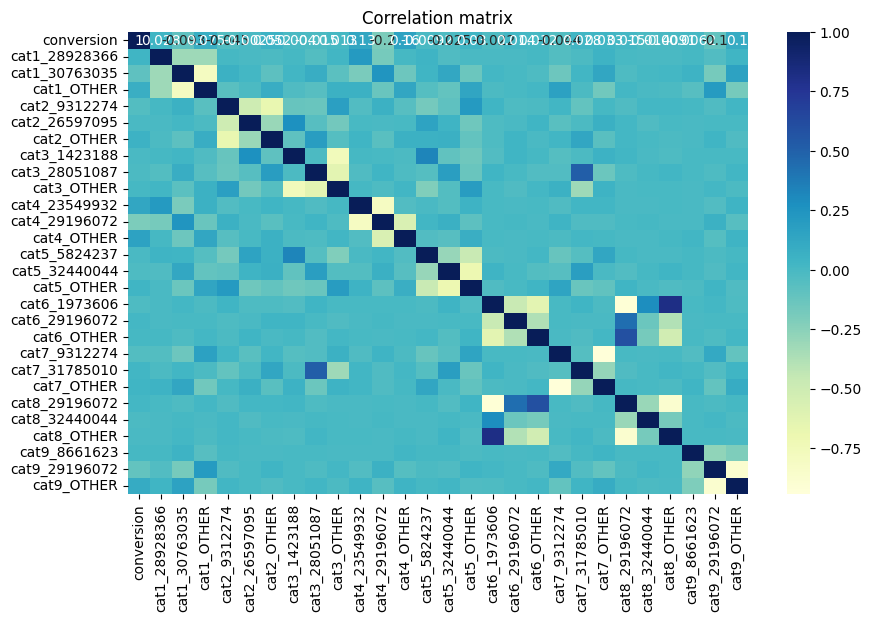

In [ ]:
# plt.figure(figsize=(10,6))
# sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)
# plt.title("Correlation matrix")

# plt.show()

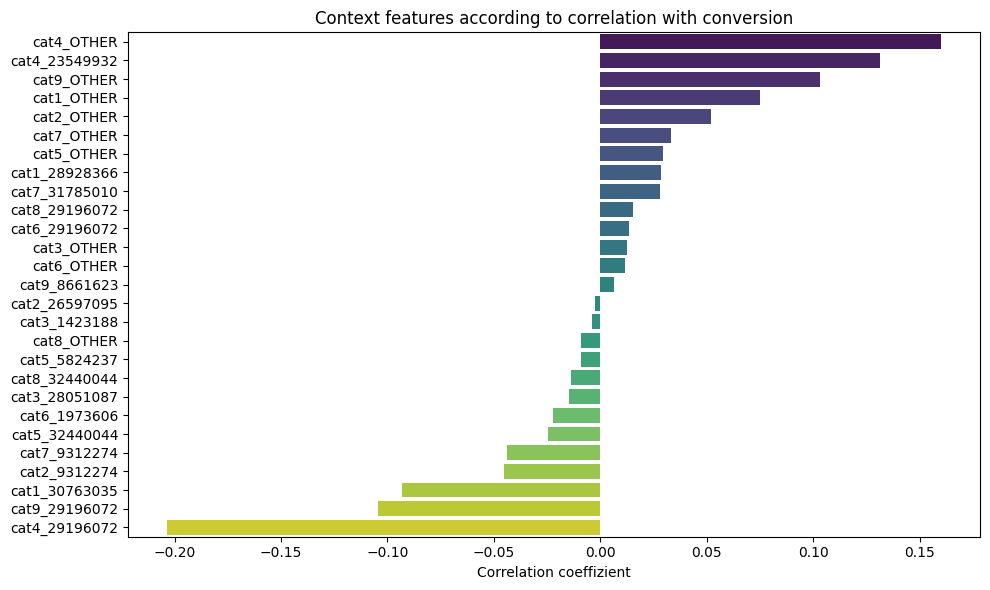

In [ ]:
conversion_corr = corr_matrix['conversion'].drop('conversion').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_corr.values, y=conversion_corr.index, palette='viridis')
plt.title("Context features according to correlation with conversion")
plt.xlabel("Correlation coeffizient")
plt.tight_layout()
plt.show()

This shows, that the cat4 columns has the highest correlation (positive or negative) with the conversions. So, in the following, I take the cat4 colums as a basis for the attribution analysis.

In order to be able to attribute the conversion success, we focus on those customer journeys which resulted in a conversion.

In [ ]:
df_conversions = df[df['conversion']==1].copy()

For the modeling, it is important to have at least two contacts in order to evaluate different attribution models. So, we analyze the data with regards to the chain length within the customer journey that led to a conversion.

In [ ]:
chain_lengths = df_conversions['uid'].value_counts()
length_distribution = chain_lengths.value_counts().sort_index()

plt.figure(figsize=(20,6))
sns.barplot(x = length_distribution.index, y = length_distribution.values, palette="viridis")

plt.title("Distribution of chain length", fontsize = 14)
plt.xlabel("Chain length (number of impressions per user)", fontsize = 12)
plt.ylabel("Number of users", fontsize = 12)

plt.show()

KeyError: 'uid'

The graph shows, that most of the chains have only one contact, so we are reducing the dataset to those customer journeys which had a conversion and at least two impressions in the chain.

## 3. Creating a subset of the dataset

In [ ]:
# Creating a subset of the dataframe with these users
valid_uids = chain_lengths[chain_lengths >= 2].index
df_subset = df_conversions[df_conversions['uid'].isin(valid_uids)].copy()

# Dropping the category columns
#df_subset.drop(["cat1","cat2", "cat3", "cat5", "cat6", "cat7", "cat8", "cat9"], axis=1, inplace=True)

In [ ]:
df_subset.head()

In [ ]:
df_subset.shape

In [ ]:
df_subset.describe()

## 4. Segmentation of the chain length

In [ ]:
chain_lengths = df_subset['uid'].value_counts()
chain_segments = pd.cut(chain_lengths, bins=[3, 10, 25, 100, np.inf], labels=["short (2-3)", "medium (4-10)", "long (11-25)", "xl (25+)"])
df_subset['chain_segment'] = df_subset['uid'].map(chain_segments)

In [ ]:
# Häufigkeit je Kettensegment
segment_counts = df_subset['chain_segment'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")

plt.title("Distribution of chain segments", fontsize=14)
plt.xlabel("Chain type", fontsize=12)
plt.ylabel("Number of users", fontsize=12)
plt.show()

## 5. Making sure, that the considered contacts in the customer journey are before the conversion

In [ ]:
# Highest conversion timestamp per user
conversion_times = df_subset.groupby('uid')['conversion_timestamp'].max()

# Creating a copy of the data subset
df_subset_check_ts = df_subset.copy()

# Mapping to the whole subset
df_subset_check_ts['max_conversion_ts'] = df_subset_check_ts['uid'].map(conversion_times)

# Flagging if conversion after the contact
df_subset_check_ts['after_conversion'] = df_subset_check_ts['timestamp'] > df_subset_check_ts['max_conversion_ts']

In [ ]:
df_subset_check_ts['after_conversion'].value_counts()

Conclusion: All contacts are before the respective conversions, so no need to exclude contacts from the data.

## 6. Creating a DataFrame for the DP6 Attribution Package

With the help of the DP6 attribution package, we can use simple heuristic models as a starting point.

The data frame has to contain the following columns: user_id, event_date (timestamp of contact), channel and conversion.

## 7. Saving the subset of the data as csv

In [ ]:
df_subset.to_csv('c:/Users/Maria/Desktop/ds_projects/attribution/data/processed/pcb_subset.csv', index=False)